# Transcription factor activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for TF activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

scRNA-seqは、それだけでは解釈が難しい多くの分子リードアウトをもたらす。これらの情報を要約する1つの方法は、事前知識から転写因子（TF）活性を推測することである。

このノートブックでは、3k PBMC 10Xデータセットを用いて、TF活性推論にdecouplerを使用する方法を紹介します。このデータは、健康なドナーの3k PBMCから構成されており、10x Genomics社からこのウェブページから自由に入手できます。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、scRNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
import scanpy as sc

In [2]:
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
import decoupler as dc

## Loading the data

We can download the data easily using `scanpy`:

データはscanpyを使って簡単にダウンロードできる：

In [4]:
adata = sc.datasets.pbmc3k_processed()

In [5]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

私たちはその中で、さまざまな種類の細胞を可視化することができる：

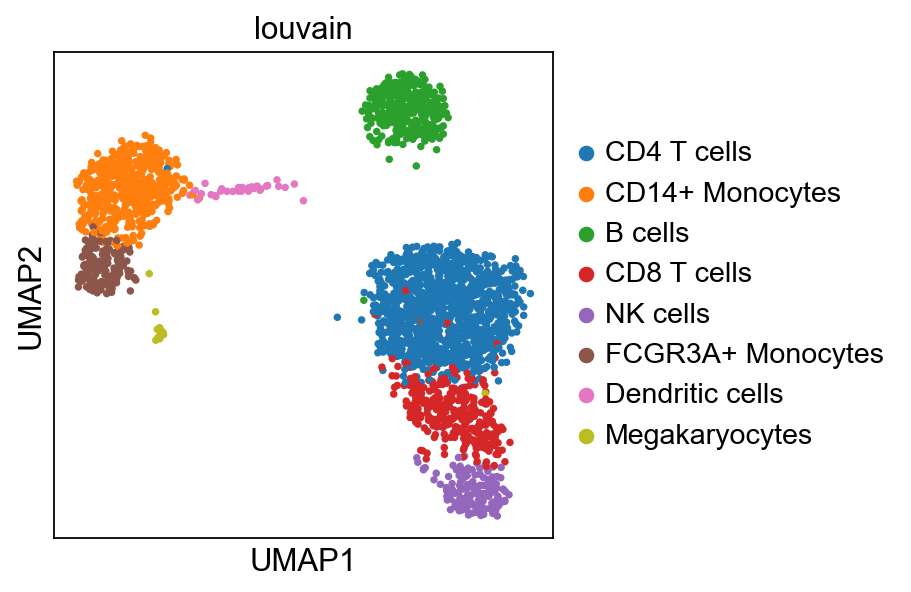

In [6]:
sc.pl.umap(adata, color='louvain')

## CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

CollecTRIは、12の異なるリソースからコンパイルされたTFとその転写ターゲットのキュレーションコレクションを含む包括的なリソースです。このコレクションは、以前のDoRothEAネットワークや他の文献ベースのGRNと比較して、転写因子のカバレッジを高め、摂動TFの同定において優れたパフォーマンスを提供します。DoRothEAと同様に、相互作用はその調節様式（活性化または阻害）によって重み付けされる。

この例ではヒトのバージョンを使用する（マウスとラットも利用可能）。decouplerを使ってomnipathから取り出すことができる。引数split_complexesは複合体を保持するかサブユニットに分割するかを指定する。デフォルトでは複合体を保持することを推奨する。

In [7]:
net = dc.get_collectri(organism='human', split_complexes=False)

In [9]:
net.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


## Activity inference with univariate linear model (ULM)

To infer TF enrichment scores we will run the univariate linear model (`ulm`) method. For each cell in our dataset (`adata`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

TF濃縮スコアを推論するために、単変量線形モデル（ulm）法を実行する。データセット(adata)の各細胞とネットワーク(net)の各TFについて、TFのTF-遺伝子相互作用重みのみに基づいて、観測された遺伝子発現を予測する線形モデルを当てはめる。フィッティング後、得られた傾きのt値がスコアとなる。これが正であればTFは活性であると解釈し、負であれば不活性であると解釈する。

decouplerを実行するには、入力行列(mat)、入力事前知識ネットワーク/リソース(net)、使用したいnetの列の名前が必要である。

In [10]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 608 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


The obtained scores (`ulm_estimate`) and p-values (`ulm_pvals`) are stored in the `.obsm` key:

得られたスコア(ulm_estimate)とp値(ulm_pvals)は.obsmキーに格納される：

In [11]:
adata.obsm['ulm_estimate'].head()

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID1B,ARID3A,ARID3B,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACATACAACCAC-1,3.105468,0.879592,2.909616,3.406131,0.822555,2.255649,0.622126,-0.454210,-0.497625,-0.454210,...,0.051970,-3.070555,-0.287258,-0.454214,0.485032,-1.168097,0.816615,-0.090827,1.496588,2.328766
AAACATTGAGCTAC-1,0.644366,-0.912154,0.994992,2.265793,0.947906,1.649951,-0.594850,-0.594846,-0.651707,-0.594846,...,-0.334580,0.798244,0.266120,0.217652,-0.651681,-0.263382,1.700061,-0.118951,2.089825,0.693020
AAACATTGATCAGC-1,2.105423,2.411347,2.517772,5.470295,2.126797,3.830123,-0.566923,-0.566920,-0.621111,0.393613,...,-0.841067,-5.552263,0.400812,0.393611,-0.621086,-0.214621,-0.206983,1.408917,1.648628,0.393655
AAACCGTGCTTCCG-1,0.276449,-0.050781,3.699017,3.061379,2.169211,4.214366,-0.523785,-0.523782,-0.573849,-0.523782,...,2.882433,-0.057149,-0.331257,-0.523789,0.356896,0.639145,0.739300,-0.104740,3.708728,2.535483
AAACCGTGTATGCG-1,2.003766,-0.067349,2.869071,3.876005,2.185347,1.854994,-0.393699,1.259139,-0.431328,-0.393696,...,1.182478,0.528311,1.057657,2.912763,-0.431311,2.207839,-0.143738,-0.078726,2.713175,-0.393741


**Note**: Each run of `run_ulm` overwrites what is inside of `ulm_estimate` and `ulm_pvals`. if you want to run `ulm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

注：run_ulmを実行するたびに、ulm_estimateとulm_pvalsの中身が上書きされます。ulmを他のリソースで実行し、同じAnnDataオブジェクトの中にアクティビティを保持したい場合は、.obsmの他のキーに異なる名前で結果を保存することができます：

In [12]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()

In [13]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

得られたスコアを視覚化するために、scanpyのプロット関数の多くを再利用することができます。しかし、最初にadataオブジェクトから得点を抽出する必要があります。

In [14]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

In [15]:
acts

AnnData object with n_obs × n_vars = 2638 × 608
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

dc.get_actsは、取得したアクティビティを.X属性に保持する新しいAnnDataオブジェクトを返すので、例えば、多くのscanpy関数を再利用することができます：

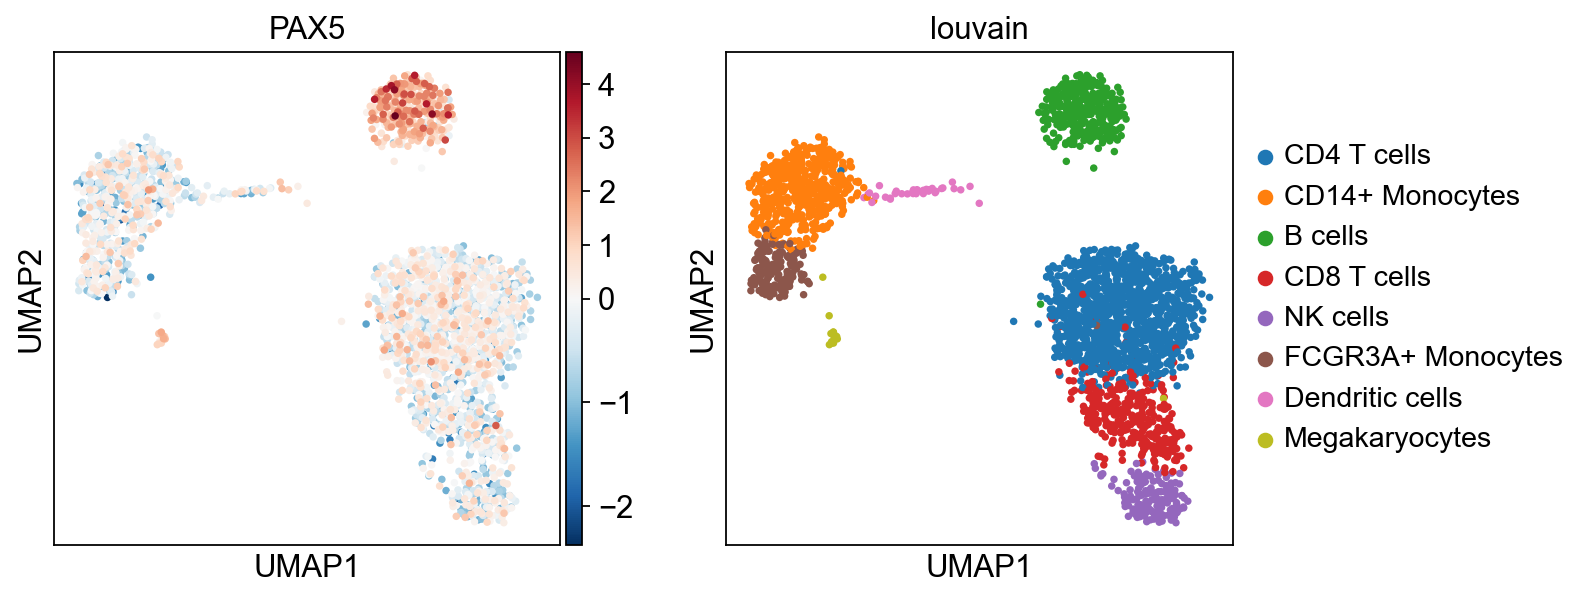

In [16]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='RdBu_r', vcenter=0)

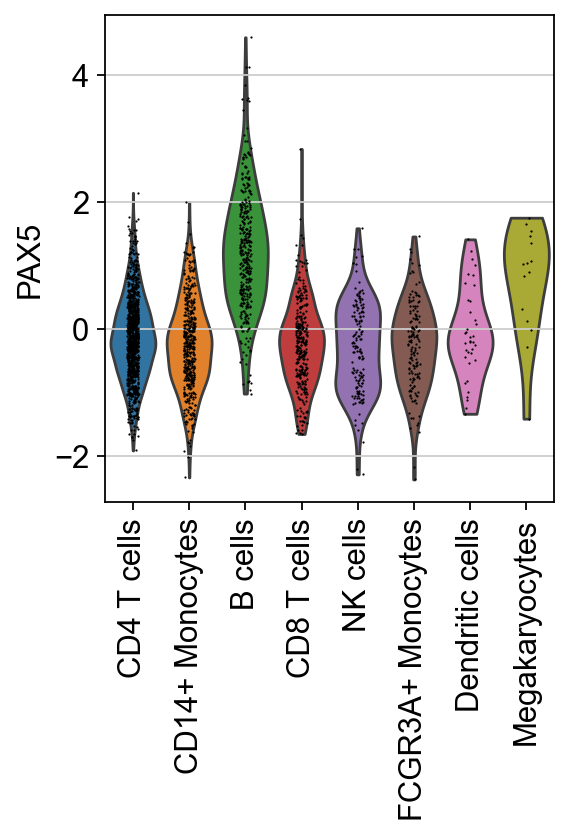

In [17]:
sc.pl.violin(acts, keys=['PAX5'], groupby='louvain', rotation=90)

Here we observe the activity infered for PAX5 across cells, which it is particulary active in B cells. Interestingly, PAX5 is a known TF crucial for B cell identity and function.
The inference of activities from "foot-prints" of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself since it is just expressed in few cells:

ここで我々は、PAX5が細胞全体にわたって活性を示し、特にB細胞で活性を示すことを観察した。興味深いことに、PAX5はB細胞のアイデンティティと機能に重要なTFとして知られている。標的遺伝子の "足跡 "から活性を推測することは、あるTFの分子的リードアウトを見るよりも有益である：

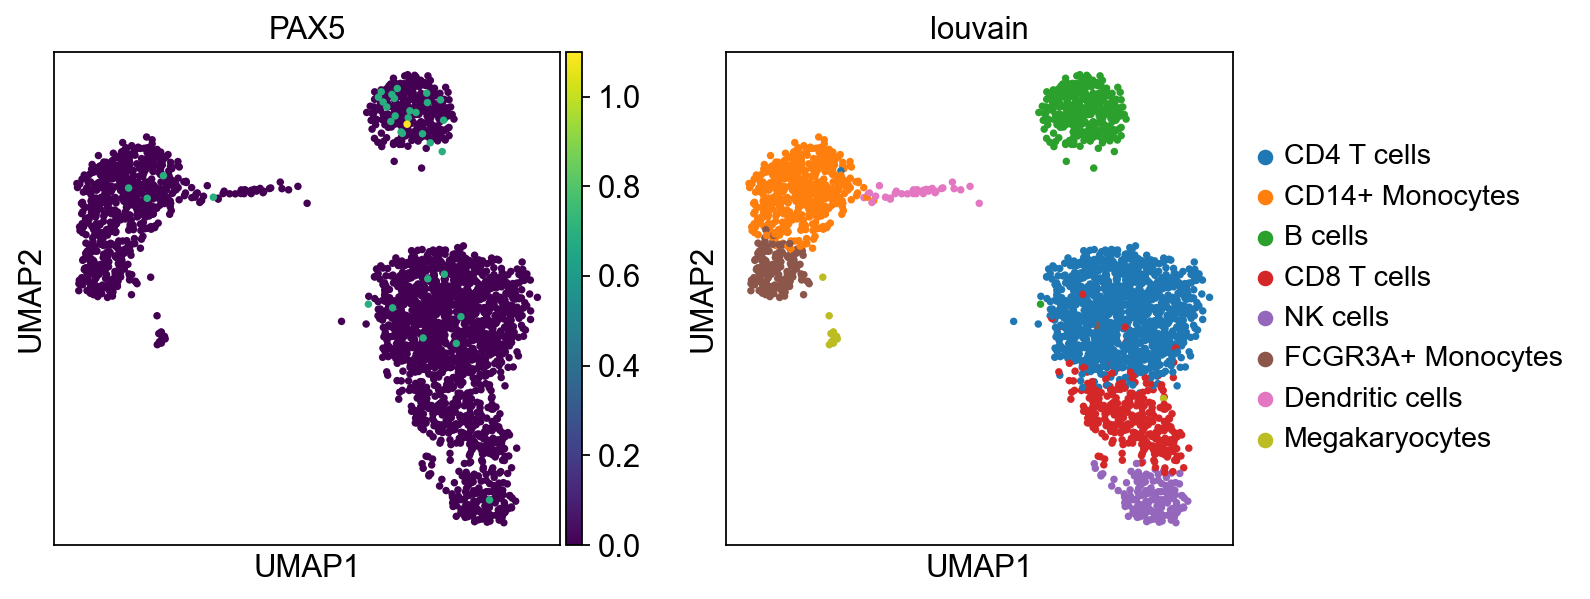

In [18]:
sc.pl.umap(adata, color=['PAX5', 'louvain'])

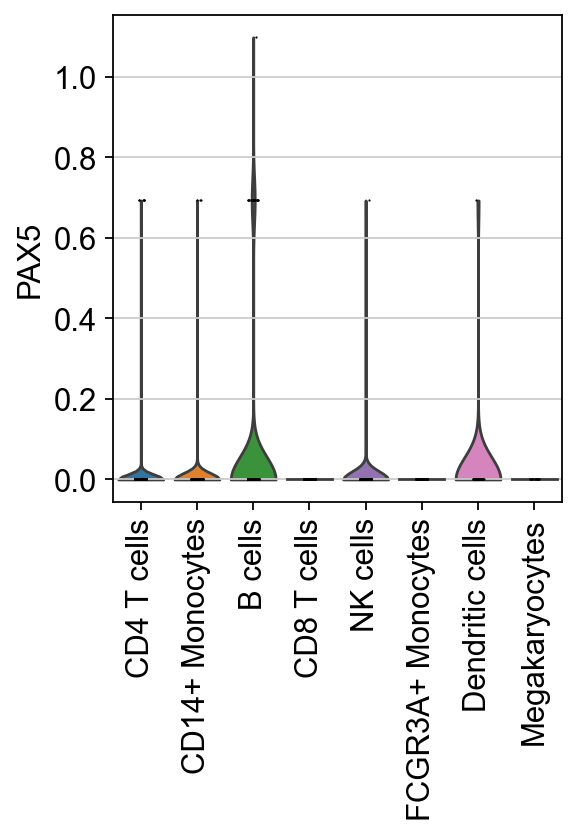

In [19]:
sc.pl.violin(adata, keys=['PAX5'], groupby='louvain', rotation=90)

## Exploration

Let's identify which are the top TF per cell type. We can do it by using the function `dc.rank_sources_groups`, which identifies marker TFs using the same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

細胞の種類ごとに、どのTFがトップであるかを特定しよう。これは、scanpyのscanpy.tl.rank_genes_groupsで利用できるのと同じ統計的検定を使ってマーカーTFを特定する。

In [20]:
df = dc.rank_sources_groups(
    acts, groupby='louvain',
    reference='rest', method='t-test_overestim_var'
)

In [21]:
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,EBF1,46.169476,2.599951,7.624389e-180,1.158907e-177
1,B cells,rest,RFXANK,41.651199,10.032308,1.121601e-186,6.819333e-184
2,B cells,rest,RFXAP,41.465607,10.624727,1.992666e-185,4.038470e-183
3,B cells,rest,RFX5,41.407183,8.863535,1.182180e-185,3.593827e-183
4,B cells,rest,CIITA,38.505507,6.445219,7.559190e-173,9.191975e-171


We can then extract the top 3 markers per cell type:

そして、細胞タイプごとに上位3つのマーカーを抽出することができる：

In [24]:
n_markers = 3

source_markers = (
    df
    .groupby('group')
    .head(n_markers)
    .groupby('group')['names']
    .apply(lambda x: list(x))
    .to_dict()
)

In [26]:
source_markers

{'B cells': ['EBF1', 'RFXANK', 'RFXAP'],
 'CD14+ Monocytes': ['ONECUT1', 'EHF', 'ELF3'],
 'CD4 T cells': ['ZBTB4', 'MYC', 'ZBED1'],
 'CD8 T cells': ['KLF13', 'NFKB2', 'RELB'],
 'Dendritic cells': ['RFXAP', 'RFXANK', 'RFX5'],
 'FCGR3A+ Monocytes': ['SIN3A', 'PPARD', 'SPIC'],
 'Megakaryocytes': ['PKNOX1', 'PBX2', 'FLI1'],
 'NK cells': ['ZGLP1', 'CEBPZ', 'ZNF395']}

We can plot the obtained markers:

得られたマーカーをプロットすることができる：

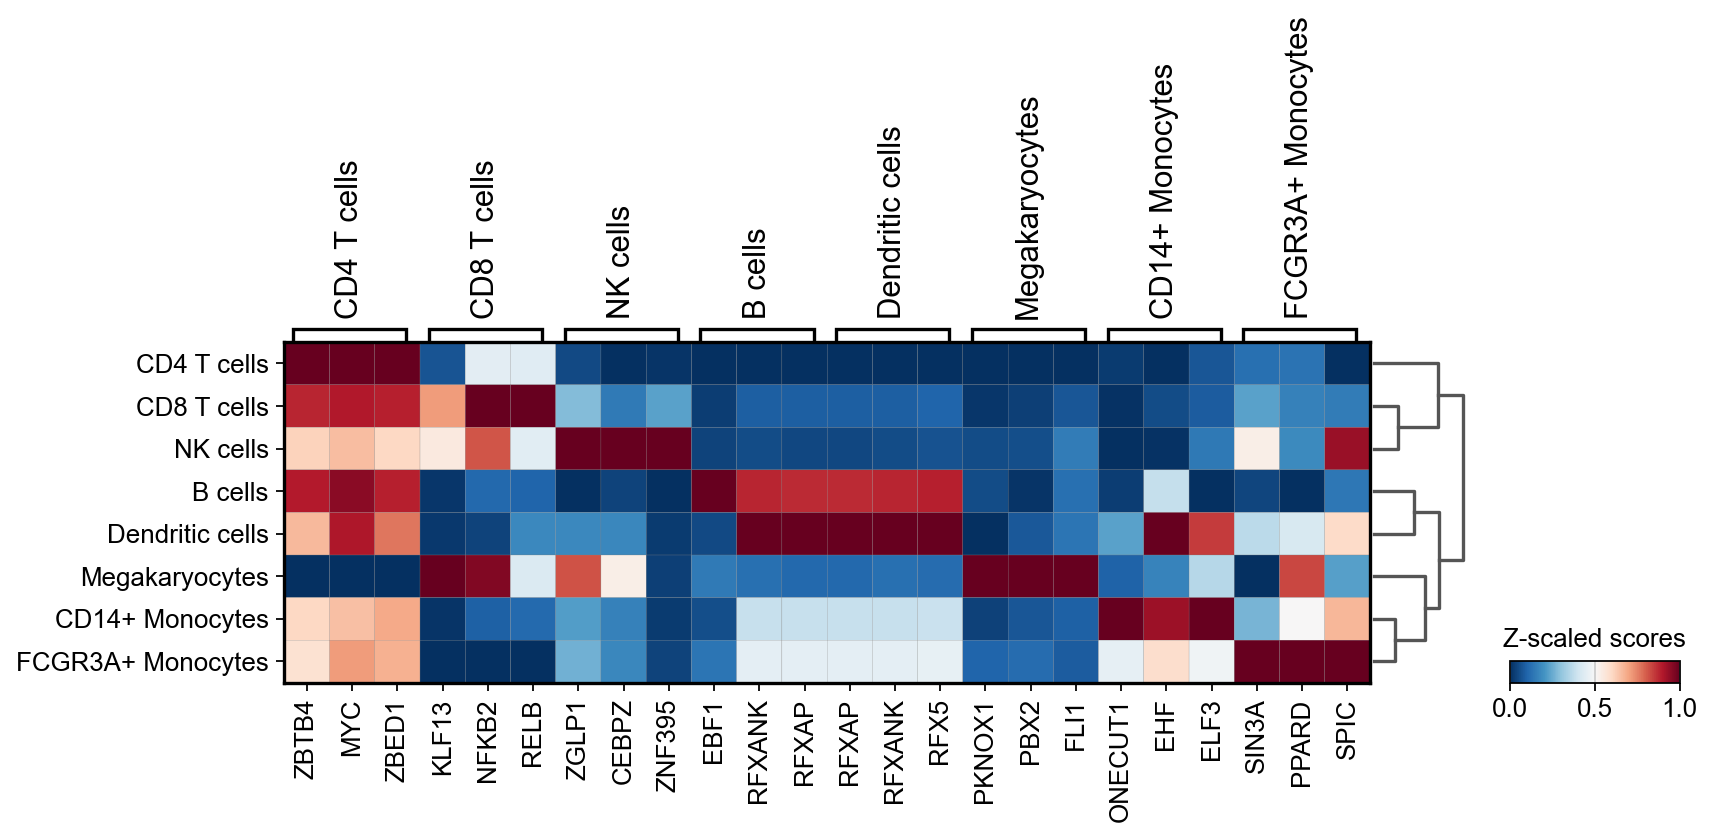

In [27]:
sc.pl.matrixplot(
    acts, source_markers, 'louvain',
    dendrogram=True, standard_scale='var',
    colorbar_title='Z-scaled scores', cmap='RdBu_r'
)

We can check individual TFs by plotting their distributions:

分布をプロットすることで個々のTFをチェックすることができる：

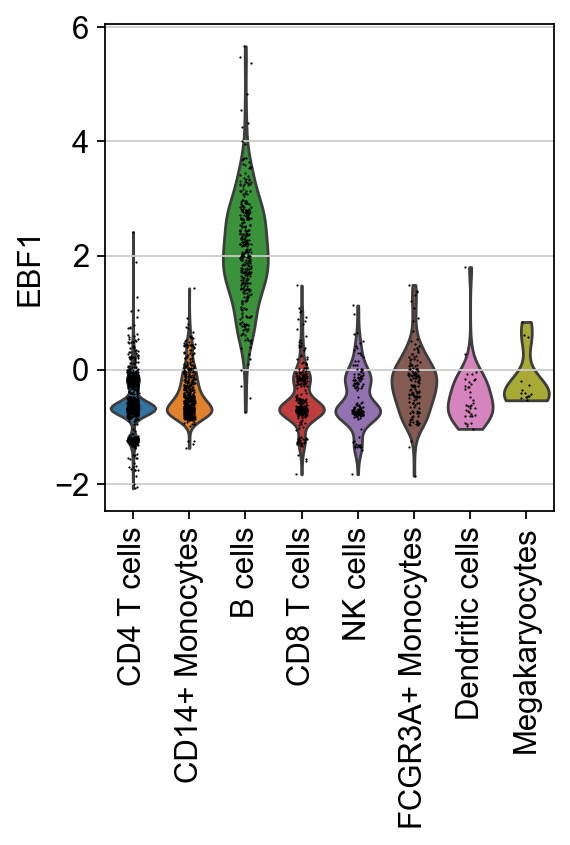

In [28]:
sc.pl.violin(acts, keys=['EBF1'], groupby='louvain', rotation=90)

Here we can observe the TF activities for EBF1, which is a known marker TF for B cells.

We can also plot `net` to see relevant TFs and target genes:

ここでは、B細胞のマーカーTFとして知られるEBF1のTF活性を観察することができる。

また、関連するTFと標的遺伝子を見るためにネットをプロットすることもできる：

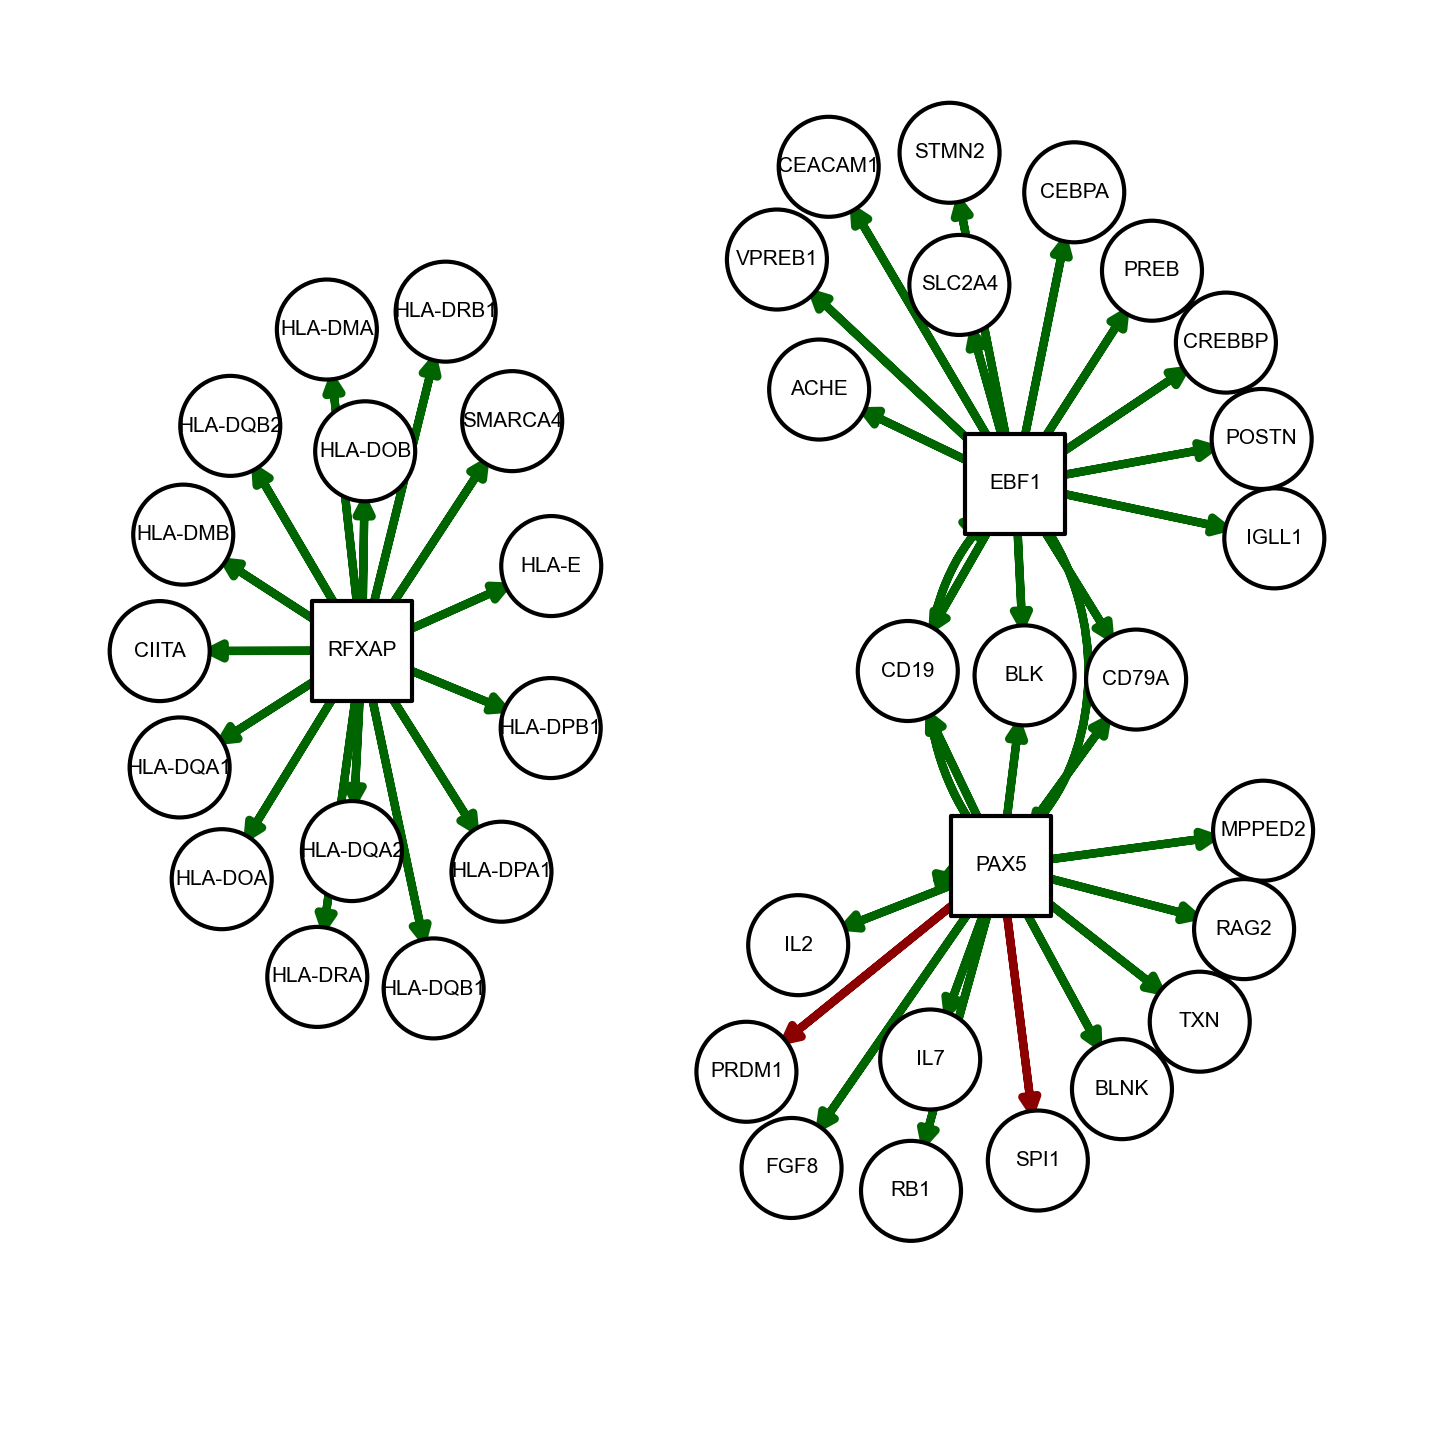

In [29]:
dc.plot_network(
    net=net,
    n_sources=['PAX5', 'EBF1', 'RFXAP'],
    n_targets=15,
    node_size=100,
    s_cmap='white',
    t_cmap='white',
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    figsize=(5, 5)
)